<a href="https://colab.research.google.com/github/SHAIK-MOHAMMAD-IRFAN27/VR-mini-project/blob/main/VR_TASK3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab import drive

drive.mount('/content/drive')

# Paths
image_folder = "/content/drive/MyDrive/MSFD/1/face_crop/"
mask_gt_folder = "/content/drive/MyDrive/MSFD/1/face_crop_segmentation/"


os.makedirs(segmented_output_folder, exist_ok=True)

image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
mask_files = [f for f in os.listdir(mask_gt_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

num_images_to_process = len(image_files)
print(f"Processing {num_images_to_process} images.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Processing 4382 images.


100%|██████████| 4382/4382 [18:01<00:00,  4.05it/s]


Mean IoU for Region Growing on  images: 0.1389


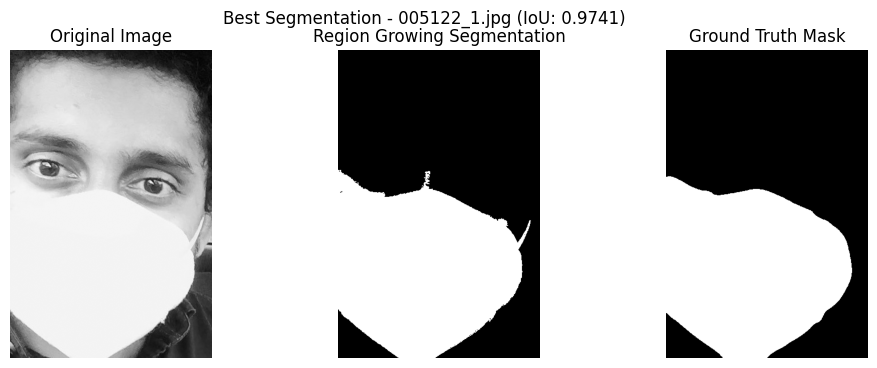

In [3]:
from sklearn.metrics import jaccard_score  # IoU Calculation

# Folder to save region-growing masks
region_growing_output_folder = "/content/drive/MyDrive/MSFD/1/region_growing_masks1/"
os.makedirs(region_growing_output_folder, exist_ok=True)

def region_growing(image, seed, threshold=15):
    """
    Perform region growing segmentation.
    - image: Grayscale input image
    - seed: (x, y) starting point
    - threshold: Maximum intensity difference allowed for region growing
    """
    h, w = image.shape
    segmented = np.zeros_like(image, dtype=np.uint8)
    visited = np.zeros_like(image, dtype=np.uint8)

    stack = [seed]  # Start with the given seed pixel
    initial_intensity = image[seed]  # Get seed intensity

    while stack:
        x, y = stack.pop()

        if visited[x, y] == 1:
            continue  # Skip already visited pixels

        visited[x, y] = 1  # Mark as visited

        # Check if intensity difference is within threshold
        if abs(int(image[x, y]) - int(initial_intensity)) <= threshold:
            segmented[x, y] = 255  # Mark as foreground

            # Add 4-neighbor pixels (ensure within image bounds)
            if x > 0: stack.append((x-1, y))
            if x < h-1: stack.append((x+1, y))
            if y > 0: stack.append((x, y-1))
            if y < w-1: stack.append((x, y+1))

    return segmented

# Initialize IoU tracking variables
ious = []
best_iou = 0
best_image = None

num_images = len(image_files)

for i in tqdm(range(num_images), total=num_images):
    img_name = image_files[i]
    mask_name = mask_files[i]

    img_path = os.path.join(image_folder, img_name)
    mask_path = os.path.join(mask_gt_folder, mask_name)

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read in grayscale
    mask_gt = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Ground truth mask

    # Resize ground truth to match input image if needed
    if img.shape != mask_gt.shape:
        mask_gt = cv2.resize(mask_gt, (img.shape[1], img.shape[0]))

    # Convert ground truth mask to binary
    mask_gt = (mask_gt > 127).astype(np.uint8)  # Thresholding

    # Choose a seed point (center of image)
    seed = (img.shape[0]//2, img.shape[1]//2)

    # Apply region growing
    segmented_mask = region_growing(img, seed)

    # Compute IoU
    segmented_binary = (segmented_mask > 127).astype(np.uint8)  # Convert to binary
    iou = jaccard_score(mask_gt.flatten(), segmented_binary.flatten(), average='binary')
    ious.append(iou)

    # Track best image based on IoU
    if iou > best_iou:
        best_iou = iou
        best_image = (img, segmented_mask, mask_gt, img_name)

    # Save output
    output_path = os.path.join(region_growing_output_folder, img_name)
    cv2.imwrite(output_path, segmented_mask)

# Compute Mean IoU
mean_iou = np.mean(ious)

print(f"Mean IoU for Region Growing on  images: {mean_iou:.4f}")

# Display best segmented image
if best_image:
    img, segmented_mask, mask_gt, img_name = best_image

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='gray')
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(segmented_mask, cmap='gray')
    plt.title("Region Growing Segmentation")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(mask_gt, cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.suptitle(f"Best Segmentation - {img_name} (IoU: {best_iou:.4f})")
    plt.show()

100%|██████████| 4382/4382 [5:28:10<00:00,  4.49s/it]


Processed 4180/4382 images.
Mean IoU Score: 0.4637


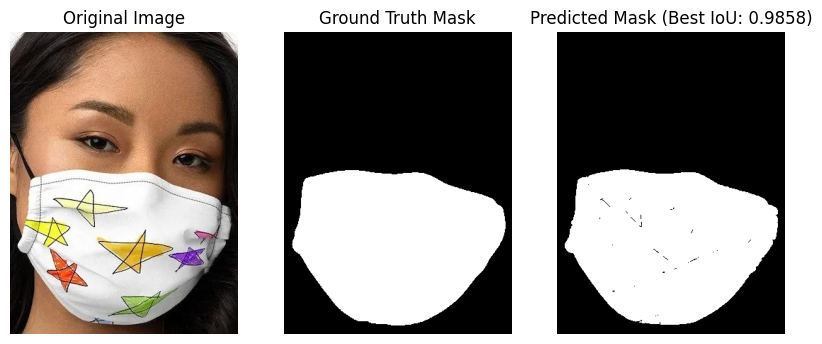

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Function to perform GrabCut segmentation
def segment_mask_grabcut(image):
    if image is None:
        return None

    h, w = image.shape[:2]
    if h < 50 or w < 50:  # Ignore very small images
        return None

    mask = np.zeros((h, w), np.uint8)
    bgd_model = np.zeros((1, 65), np.float64)
    fgd_model = np.zeros((1, 65), np.float64)

    rect = (10, 10, w - 20, h - 20)  # Define ROI for GrabCut

    try:
        cv2.grabCut(image, mask, rect, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_RECT)
    except cv2.error:
        return None

    return np.where((mask == 1) | (mask == 3), 1, 0).astype("uint8")

# Compute Intersection over Union (IoU)
def compute_iou(pred_mask, gt_mask):
    intersection = np.logical_and(pred_mask, gt_mask)
    union = np.logical_or(pred_mask, gt_mask)
    return np.sum(intersection) / np.sum(union) if np.sum(union) > 0 else 0

# Folder paths
image_folder = "/content/drive/MyDrive/MSFD/1/face_crop/"
mask_gt_folder = "/content/drive/MyDrive/MSFD/1/face_crop_segmentation/"
segmented_grabcut_folder = "/content/drive/MyDrive/MSFD/1/segmented_masks_gc/"


# Get image and mask file names
image_files = sorted(os.listdir(image_folder))
mask_files = sorted(os.listdir(mask_gt_folder))

num_images_to_process = min(len(image_files), len(mask_files))  # Ensure same number of images and masks

iou_scores = []
best_iou = -1
best_image = None
best_mask = None
best_pred_mask = None
os.makedirs(segmented_grabcut_folder, exist_ok=True)

for i in tqdm(range(num_images_to_process)):
    image_path = os.path.join(image_folder, image_files[i])
    gt_mask_path = os.path.join(mask_gt_folder, mask_files[i])

    image = cv2.imread(image_path)
    gt_mask = cv2.imread(gt_mask_path, cv2.IMREAD_GRAYSCALE)

    if image is None or gt_mask is None:
        continue

    # Convert ground truth mask to binary
    gt_mask = (gt_mask > 127).astype("uint8")

    # Perform segmentation
    pred_mask = segment_mask_grabcut(image)
    if pred_mask is None:
        continue

    # Resize ground truth mask to match predicted mask
    gt_mask = cv2.resize(gt_mask, (pred_mask.shape[1], pred_mask.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Compute IoU
    iou = compute_iou(pred_mask, gt_mask)
    iou_scores.append(iou)

    # Create output visualization
    output_image = np.zeros_like(image)
    output_image[pred_mask == 1] = [0, 255, 0]  # Green color for segmented regions
    output_path = os.path.join(segmented_grabcut_folder, f"segmented_{image_files[i]}")
    cv2.imwrite(output_path, output_image)

    # Keep track of best IoU result
    if iou > best_iou:
        best_iou = iou
        best_image = image.copy()
        best_mask = gt_mask.copy()
        best_pred_mask = pred_mask.copy()

# Print results
print(f"Processed {len(iou_scores)}/{num_images_to_process} images.")
print(f"Mean IoU Score: {np.mean(iou_scores) if iou_scores else 0:.4f}")

# Display best segmentation result
if best_image is not None:
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(best_image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(best_mask, cmap="gray")
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(best_pred_mask, cmap="gray")
    plt.title(f"Predicted Mask (Best IoU: {best_iou:.4f})")
    plt.axis("off")

    plt.show()
else:
    print("No valid images were processed.")
